**Heidelberg University**

**Data Science  Group**
    
Prof. Dr. Michael Gertz  

Ashish Chouhan, Satya Almasian, John Ziegler, Jayson Salazar, Nicolas Reuter
    
November 13, 2023
    
Natural Language Processing with Transformers

Winter Semster 2023/2024     
***

# Team members
- Agata Kaczmarek
- Pranjal Sharma
- Jan Smoleń
- Mateusz Stączek

# **Assignment 2: “Sequence Models”**
**Due**: Monday, November 27, 2pm, via [Moodle](https://moodle.uni-heidelberg.de/course/view.php?id=19251)



### **Submission Guidelines**

- Solutions need to be uploaded as a **single** Jupyter notebook. You will find several pre-filled code segments in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do **not** hand in a separate file for it.
- Download the .zip file containing the dataset but do **not** upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the complete names of all team members are given in the notebook.

***

## **Task 1: Part-of-Speech Tagging with a Bidirectional LSTM**  (2+4+5=11 points)

In this task we will be building a sequence tagger that produces an output for every element in an input sequence, using `PyTorch` and `TorchText`, where `TorchText` consists of data processing utilities and popular datasets for natural language.


*   **input:** a sequence of text
*   **output:** part-of-speech (POS) tag for each token in the input text

We tackle this task using a multi-layer bi-directional LSTM (BiLSTM) to predict POS tags using the [Universal Dependencies](https://universaldependencies.org/) English Web Treebank (UDPOS) dataset. This dataset is contained in the `TorchText` library and we do not require an external file for it. The dataset in  `TorchText`  has two different sets of tags, universal dependency (UD) tags and Penn Treebank (PTB) tags. We only focus on the UD tags for this assignment.

In [2]:
%pip install portalocker

In [3]:
%pip install torchdata

In [4]:
%pip install torchtext

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import UDPOS

import numpy as np

import time
import random
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# for reproducibility
random.seed(77)
np.random.seed(77)
torch.manual_seed(77)
torch.backends.cudnn.deterministic = True

### Subtask 1: Data Analysis
The very basic components of the torchtext library include `vocab`, `word vectors`, and `tokenizer`. Those are the basic data processing building blocks for the raw text string.
In this case, we use the tokenizer and the vocabulary. Use the `build_vocab_from_iterator` to create the vocabulary for the text field and add the `<unk>` and `<pad>` tokens to it. Use a minimal frequency of `2`.
Also create a vocabulary for the labels (tag field). However, since the tags are predefined elements, you will not need an `<unk>` token.
 This dataset actually has two different sets of tags, universal dependency (UD) tags and Penn Treebank (PTB) tags. We train our model on the UD tags, which is the second element on the list of outputs (example below).


In [6]:
train_iter = iter(UDPOS(split="train"))
print(next(train_iter))

[['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.'], ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'], ['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']]


In [7]:
print(f"Number of training examples: {len(list(UDPOS(split='train')))}")
print(f"Number of validation examples: {len(list(UDPOS(split='valid')))}")
print(f"Number of testing examples: {len(list(UDPOS(split='test')))}")

Number of training examples: 12543
Number of validation examples: 2002
Number of testing examples: 2077


Note that the data is already tokenized!

In [8]:
train_iter = UDPOS(split="train") # to get the training set

### your code (make sure pad has id of 0) ####

train_iter_0 = [example[0] for example in train_iter]
vocab = build_vocab_from_iterator(train_iter_0, min_freq=2, specials=['<pad>', '<unk>'])
vocab.set_default_index(1)

train_iter_1 = [example[1] for example in train_iter]
ud_vocab = build_vocab_from_iterator(train_iter_1, specials=['<pad>'])

### your code ####


Prepare a text processing pipeline that takes raw input and labels and converts them to ids.

In [11]:
text_pipeline = lambda x: vocab(x)
label_pipeline = lambda x: ud_vocab(x)

In [12]:
print(text_pipeline(['the', 'preacher','at', 'mosque', "<pad>","pppp"])) #should output [3, 9271, 35, 9097, 0, 1]
print(label_pipeline(['DET', 'ADJ', 'NOUN', 'PUNCT'])) # should output [6, 8, 1, 2]

[3, 9271, 35, 9097, 0, 1]
[6, 8, 1, 2]


In [13]:
print(f"Unique tokens in input vocabulary: {len(vocab)}")
print(f"Unique tokens in UD vocabulary: {len(ud_vocab)}")

Unique tokens in input vocabulary: 9875
Unique tokens in UD vocabulary: 18


Write a custom function for the dataloader that applies the text and label pipeline and pads the sequences to have equal lengths.

In [14]:
from functools import partial

def collate_batch(batch, pad_token_ix, pad_token_ix_ud):
    ### your code ###
    max_length=0
    x_list=[[] for _ in range(len(batch))]
    y_list=[[] for _ in range(len(batch))]
    for i, example in enumerate(batch):
        len_example=len(example[0])
        if len_example>max_length:
          max_length=len_example
        x_list[i]=example[0]
        y_list[i]=example[1]

    for i in range(len(x_list)):
      x_list[i] = text_pipeline(x_list[i])
      y_list[i] = label_pipeline(y_list[i])

    x_padded = [[pad_token_ix for _ in range(max_length)] for _ in range(len(x_list))]
    y_padded = [[pad_token_ix_ud for _ in range(max_length)] for _ in range(len(y_list))]

    for i in range(len(x_list)):
      x_padded[i][:len(x_list[i])]=x_list[i]
      y_padded[i][:len(y_list[i])]=y_list[i]

    x_padded=torch.from_numpy(np.array(x_padded)) #padded input
    y_padded=torch.from_numpy(np.array(y_padded)) #padded predictions

    ### your code ###

    return x_padded.to(device), y_padded.to(device)

collate_fn = partial(collate_batch, pad_token_ix=vocab['<pad>'], pad_token_ix_ud=ud_vocab['<pad>'])


train_dataloader = DataLoader(
    UDPOS(split="train"), batch_size=128, shuffle=False, collate_fn=collate_fn
)
valid_dataloader = DataLoader(
    UDPOS(split="valid"), batch_size=128, shuffle=True, collate_fn=collate_fn
)
test_dataloader = DataLoader(
    UDPOS(split="test"), batch_size=128, shuffle=True, collate_fn=collate_fn
)

In [15]:
for idx, (text, label) in enumerate(train_dataloader):
      print(label.shape)
      print(text.shape)
      print(label[0])
      print(text[0])
      break

torch.Size([128, 76])
torch.Size([128, 76])
tensor([7, 2, 7, 2, 8, 1, 3, 7, 7, 7, 2, 7, 2, 6, 1, 5, 6, 1, 5, 6, 1, 5, 7, 2,
        5, 6, 8, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')
tensor([ 262,   16, 5728,   45,  289,  701, 1160, 4436,    1,  585,   16,    1,
           4,    3, 9271,   35,    3, 9097,   10,    3,  500,    8, 7676,    4,
         762,    3, 2242, 1610,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0], device='cuda:0')


Let's take a closer look at the data and the distribution of tags.
Implement `tag_percentage`:

*   Use the `collection.counter` to count the unique instances of each tag.

*    Compute the percentage of each tag in the entire set, by using the counted frequencies.



In [16]:
from collections import Counter

def tag_percentage(training_iterator):
    train_iter_1 = [token for example in training_iterator for token in example[1]]
    counter = Counter(train_iter_1)
    #### your code to count the number of tags
    keys_counter=counter.keys()
    suma=counter.total()
    ### compute the tag percentages based on the counter object

    tag_p=[0 for _ in range(len(keys_counter))]
    for i, key in enumerate(keys_counter):
      percentage=counter[key]/suma
      tag_p[i]=(key, counter[key], percentage)
    ###
    return tag_p

In [17]:
print("Tag\t\tCount\t\tPercentage\n")

for tag, count, percent in tag_percentage(UDPOS(split='train')):
    print(f"{tag}\t\t{count}\t\t{percent*100:4.1f}%")

Tag		Count		Percentage

PROPN		12946		 6.3%
PUNCT		23679		11.6%
ADJ		12477		 6.1%
NOUN		34781		17.0%
VERB		23081		11.3%
DET		16285		 8.0%
ADP		17638		 8.6%
AUX		12343		 6.0%
PRON		18577		 9.1%
PART		5567		 2.7%
SCONJ		3843		 1.9%
NUM		3999		 2.0%
ADV		10548		 5.2%
CCONJ		6707		 3.3%
X		847		 0.4%
INTJ		688		 0.3%
SYM		599		 0.3%


####${\color{red}{Comments\ 1.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: The Model

We start by creating a simple model and then make it more complex in later subtasks. The class `BiLSTMTagger` must subclass the `nn.Module` class of `PyTorch`. Fill the blank in the class by following the notes described below.
1.   The input is a sequence of tokens, $X = \{x_1, x_2,...,x_T\}$.
2.   Each token passes through  an embeddings layer, $e(X) = \{e(x_1), e(x_2), ..., e(x_T)\}$. Use `nn.Embedding` for the embedding layer and make sure to pass in the index of the pad token.
3. Embedding is processed by forward and backward LSTMs from left to right and right to left.  The first input to the forward LSTM is $x_1$ and the first input to the backward LSTM is $x_T$. The hidden state of LSTMs is dependent on
the hidden, $h$, and cell, $c$, states from the previous time-steps:
$$h^{\rightarrow}_t = \text{LSTM}^{\rightarrow}(e(x^{\rightarrow}_t), h^{\rightarrow}_{t-1}, c^{\rightarrow}_{t-1})$$
$$h^{\leftarrow}_t=\text{LSTM}^{\leftarrow}(e(x^{\leftarrow}_t), h^{\leftarrow}_{t-1}, c^{\leftarrow}_{t-1})$$
4. The hidden, $h$, and cell, $c$ of each layer is passed to the next layer, where the $h_0$ and $c_0$, for each direction and layer, are initialized to a tensor full of zeros. Use `nn.LSTM` for LSTM cells. How can you make it bidirectional?
5. Final hidden state is the concatenation of forward and backward hidden states from the final layer of the LSTM, $H = \{h_1, h_2, ... h_T\}$, where $h_1 = [h^{\rightarrow}_1;h^{\leftarrow}_T]$, $h_2 = [h^{\rightarrow}_2;h^{\leftarrow}_{T-1}]$. Use `nn.Linear` here.
6. The last layer is linear layer $f$, which is used to make the prediction of which tag applies to this token, $\hat{y}_t = f(h_t)$.
7. Define a `nn.Dropout` layer to apply to the embeddings and the outputs of the final layer of the LSTM.

In [18]:
class BiLSTMTagger(nn.Module):
    def __init__(self, hyperparameters):
      '''
      hyperparameters: is a dictionary containing:
                 input_dim: dimension of the input
                 embedding_dim: dimension of the embedding layer
                 lstm_hidden_dim: dimension of the hidden state of lstms
                 output_dim: dimension of the output hidden layer
                 n_layers: number of layers to stack
                 bidirectional: is the lstm bi-directional
                 dropout: probability for the drop out layer
                 pad_idx: id of the pad token
      '''
      super().__init__()
       #### your code ####
      #embedding layer
      self.embedding = nn.Embedding(num_embeddings=hyperparameters['input_dim'],
                                    embedding_dim=hyperparameters['embedding_dim'],
                                    padding_idx=hyperparameters['pad_idx']
                                    )
      #bi-lstm, apply dropout if the number of layers is more than 1
      if hyperparameters['n_layers']>1:
        dropout_param = hyperparameters['dropout']
      else:
        dropout_param = 0.0
      self.lstm = nn.LSTM(input_size=hyperparameters['embedding_dim'],
                          hidden_size=hyperparameters['lstm_hidden_dim'],
                          num_layers=hyperparameters['n_layers'],
                          bidirectional=hyperparameters['bidirectional'],
                          batch_first=True)
      self.fc = nn.Linear(in_features=hyperparameters['lstm_hidden_dim']*(hyperparameters['bidirectional'] +1),
                          out_features=hyperparameters['output_dim'])

      self.dropout = nn.Dropout(hyperparameters['dropout'])
      #### your code ####
    def forward(self, text, debug=False): #(B,S)
      '''
      S: sentence len
      B: batch size
      E: embedding size
      H: hidden size
      O: output size
      L: number of layers
      '''
      #### your code ####
      #pass text through embedding layer and a drop out layer
      embd = self.embedding(text)
      drop_embd = self.dropout(embd)

      #pass embeddings into bi-LSTM
      outputs, (hidden, cell) = self.lstm(drop_embd)
      output_drop=self.dropout(outputs)

      #compute prediction
      predictions = self.fc(output_drop)
      #### your code ####

      if debug==True:
        print("Input shape:",text.shape)
        print("Embedding shape:",embd.shape)
        print("LSTM output shape:",outputs.shape)
        print("LSTM hidden shape:",hidden.shape)
        print("LSTM cell shape:",cell.shape)
        print("Output shape:",predictions.shape)

      return predictions

Response in plain text:
1. Based on the notation defined in the forward function. What is the dimension of `outputs`, `hidden`, and `cell`?

S: sentence len
      B: batch size
      E: embedding size
      H: hidden size
      O: output size
      L: number of layers

`outputs` = $(B, S, D*H)$, where D = 2 if bidirectional=True, otherwise is 1

`hidden` = $(D*L, B, H)$

`cell` = $(D*L, B, H)$

In [19]:
hyper_parameters={
  'input_dim':  len(vocab),
  'embedding_dim': 100,
  'lstm_hidden_dim': 128,
  'output_dim':len(ud_vocab),
  'n_layers': 2 ,
  'bidirectional':True,
  'dropout': 0.25,
  'pad_idx': vocab['<pad>']
}
model = BiLSTMTagger(hyper_parameters)

In [21]:
input=torch.tensor([[3, 9271, 35, 9097, 0, 1],
                    [3, 9271, 35, 9097, 0, 1]])
model(input,debug=True).shape

Input shape: torch.Size([2, 6])
Embedding shape: torch.Size([2, 6, 100])
LSTM output shape: torch.Size([2, 6, 256])
LSTM hidden shape: torch.Size([4, 2, 128])
LSTM cell shape: torch.Size([4, 2, 128])
Output shape: torch.Size([2, 6, 18])


torch.Size([2, 6, 18])

Weights of the network are initialized randomly, so let's make a more systematic initialization to help us with the optimization. For example,  Xavier Initialization creates weights such that the variance of the activations is the same across every layer. This constant variance helps prevent the gradient from exploding or vanishing. However, it does not apply to bias terms.

Create a function that uses Xavier Initialization to initialize the weights of the network, for biases use a normal distribution with a mean of 0 and a standard deviation of 0.1.

In [23]:
def init_weights(m):
  ### you code ###
  names_of_keys=m.state_dict().keys()
  for key in names_of_keys:
    if 'weight' in key:
      #apply xavier
      m.state_dict()[key] = nn.init.xavier_normal_(m.state_dict()[key])
    elif 'bias' in key:
      #use normal distribution
      m.state_dict()[key] = np.random.normal(0, 0.1)
  ### your code ###
model.apply(init_weights)
model.to(device)

BiLSTMTagger(
  (embedding): Embedding(9875, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=18, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Let's count the number of trainable parameters in our model.

In [24]:
def count_parameters(model):
  ### your code ###
  sum=0
  for p in model.parameters():
    if p.requires_grad:
      sum +=torch.numel(p)
  return sum
  ### your code ###

print("number of trainable parameters:",count_parameters(model))

number of trainable parameters: 1622910


####${\color{red}{Comments\ 1.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Training

We start by defining a loss function and an optimizer.


*   **optimizer:** We use Adam with the learning rate=0.0001.
*   **loss:** We use cross-entropy loss.

Even though we have no `<unk>` tokens within our tag vocab, we still have `<pad>` tokens to create batches of the same size. However, we do not want to calculate loss on those tokens, so make sure you define your loss function in such a way that ignores the `<pad>` tokens.




In [25]:
### your code ###
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
### your code ###

Watching the loss go down as you train a model is a good indication of the correct training procedure, but does not tell us how well we are doing on a given task.
To this end, we also implement a categorical accuracy measure to keep track of how well our model is doing on a given task.
Same as before: we don't want to calculate accuracy over the `<pad>` tokens as we aren't interested in predicting them.
Implement the function `categorical_acc` to compare the prediction of non-pad tokens with labels count the correct ones and calculate the accuracy over a single batch.

In [27]:
def categorical_acc(preds, gt, pad_idx):
    """
    Returns categorical accuracy per batch
    """
    ### your code ####
    max_preds =  preds.argmax(dim=-1) # get the index of the max probability
    max_preds = max_preds.flatten()
    gt=gt.flatten()
    non_padded_indices = gt.ne(0)
    acc = sum(max_preds[non_padded_indices] == gt[non_padded_indices])/sum(non_padded_indices)
    return acc
    ### your code ####

In [32]:
dummpy_input=torch.tensor([
    [0.9,0,0,0],
    [0.1,0.9,0,0],
    [0.1,0,0,0.9],
    [0.9,0.1,0,0],
    [0.1,0.8,0,0]

])
categorical_acc(dummpy_input, torch.tensor([0,2,3,0,1]), 0)

tensor(0.6667)

Define the `train` model that performs one epoch of training. You can refer to the Tutorial 2 of the course to get a sample workflow. The only difference to the tutorial is that we keep track of the batch-wise accuracy as well as the loss.

In [34]:
def train(model, dataloader, optimizer, loss_function, pad_idx):

    epoch_loss = 0
    epoch_acc = 0

    model.train()
    epoch_start_time = time.time()

    for length_dataloader,(text,tags) in enumerate(dataloader):
        #### your code ####
        optimizer.zero_grad()
        outputs = model(text)
        loss=loss_function(outputs.view(-1, outputs.size(-1)), tags.flatten())
        loss.backward()
        acc = categorical_acc(outputs, tags, pad_idx)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc

        #### your code ####
    end_time= time.time() - epoch_start_time
    return epoch_loss / length_dataloader, epoch_acc / length_dataloader,end_time

It is not enough to only look at the training loss and accuracy, since with more training, we can always do better on the training set, but lose the generalizability to unseen data, a phenomenon known as **overfitting**. Therefore, it is important to check the loss and accuracy on the validation set after each epoch and stop before  overfitting occurs. Moreover, we can use the validation metric as an indication of which checkpoint of our model is the best.

Define an `evaluate` function that runs once through the validation set and computes loss and accuracy. **Note:** You should not be updating gradients here and your model should be in evaluation mode.

In [35]:
def evaluate(model, dataloader, loss_function, pad_idx):

    val_loss = 0
    val_acc = 0

    ### your code ###
    model.eval()
    with torch.no_grad():
      for length_dataloader,(text,tags) in enumerate(dataloader):
          outputs = model.forward(text)
          output_argmax=  outputs.argmax(dim=1)
          loss = loss_function(outputs.view(-1, outputs.size(-1)), tags.flatten())
          acc = categorical_acc(outputs, tags, pad_idx)
          val_loss += loss.item()
          val_acc += acc

     ### your code ###

    return val_loss / length_dataloader, val_acc / length_dataloader

Let's use the functions defined so far and train our model for `30` epochs. We suggest using GPU for this task, as it is quite slow on the CPU. Run the training loop for the given number of epochs and calculate the validation metric at the end of each epoch. Based on the validation loss, save the best checkpoint of the model.

In [37]:
epochs = 30

best_valid_loss = float('inf')

for epoch in range(epochs):
    ### your code ###
    train_loss, train_acc, epoch_time = train(model, train_dataloader, optimizer, loss_function, vocab['<pad>'])
    valid_loss, valid_acc = evaluate(model, valid_dataloader, loss_function, vocab['<pad>'])
    if valid_loss<best_valid_loss:
      best_valid_loss=valid_loss
      torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'valid_loss': valid_loss,
            }, 'best_model_checkpoint.pth')

    ### your code ###
    elapsed_mins = int(epoch_time / 60)
    elapsed_secs = int(epoch_time - (elapsed_mins * 60))
    print(f'Epoch: {epoch+1:02} | Epoch Time: {elapsed_mins}m {elapsed_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Validation Loss: {valid_loss:.3f} |  Validation Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Epoch: 01 | Epoch Time: 0m 14s
	Train Loss: 2.717 | Train Acc: 15.29%
	 Validation Loss: 2.716 |  Validation Acc: 17.84%
Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 2.548 | Train Acc: 17.24%
	 Validation Loss: 2.670 |  Validation Acc: 18.85%
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 2.474 | Train Acc: 20.76%
	 Validation Loss: 2.521 |  Validation Acc: 27.10%
Epoch: 04 | Epoch Time: 0m 13s
	Train Loss: 2.223 | Train Acc: 29.22%
	 Validation Loss: 2.115 |  Validation Acc: 38.50%
Epoch: 05 | Epoch Time: 0m 14s
	Train Loss: 1.750 | Train Acc: 46.01%
	 Validation Loss: 1.591 |  Validation Acc: 58.74%
Epoch: 06 | Epoch Time: 0m 14s
	Train Loss: 1.303 | Train Acc: 62.58%
	 Validation Loss: 1.218 |  Validation Acc: 70.41%
Epoch: 07 | Epoch Time: 0m 16s
	Train Loss: 1.018 | Train Acc: 71.57%
	 Validation Loss: 0.996 |  Validation Acc: 77.46%
Epoch: 08 | Epoch Time: 0m 13s
	Train Loss: 0.839 | Train Acc: 77.36%
	 Validation Loss: 0.852 |  Validation Acc: 82.83%
Epoch: 09 | Epoch Time: 0m 13s
	

Question:

1. Does overfitting occur? If so, after which epochs?

2. How do you detect overfitting?


**Answer:**
```
1. For our model we can speculate that we see start of overfitting in 30th epoch - the validation loss is equal to the one in epoch 29, but the training loss is still decreasing.
2. To detect overfitting we compare the performance on training and validation datasets during the training. If the model performs better and better on the training set, but starts to get worse on the validation one, we can speak about overfitting.
```

Let's see how well our model is doing on the test set. Load the best checkpoint and calculate the accuracy.

In [38]:
#### you code ####
model_best = BiLSTMTagger(hyper_parameters)
checkpoint = torch.load('best_model_checkpoint.pth')
model_best.load_state_dict(checkpoint['model_state_dict'])
test_loss, test_acc = evaluate(model, test_dataloader, loss_function, vocab['<pad>'])
#### you code ####
test_acc

tensor(0.9589, device='cuda:0')

####${\color{red}{Comments\ 1.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4: Inference

Let's use the model we trained to tag some actual sentences. We have the preprocessing pipeline ready from Subtask 1, now we need to map the predictions back to label texts for each token.

Implement the `tag_sequence` function that takes a model and a sentence as input and generates POS tags. Keep in mind that you need to divide the sentence into tokens first. For this purpose, we just split each sentence on whitespaces.

In [163]:
def tag_sentence(model, sentence):
    ### your code ###
    sentence=text.split(" ")
    sentence_coded = torch.tensor(text_pipeline(sentence)).unsqueeze(dim=0).cuda()
    predictions=np.array(model(sentence_coded).argmax(dim=2).cpu())[0]
    predicted_tags=["" for i in range(len(predictions))]
    for i in range(len(predictions)):
      predicted_tags[i]=ud_vocab.get_itos()[predictions[i]]

    ### your code ###
    return predicted_tags

In [164]:
text=" ".join(list(UDPOS(split='test'))[0][0])
label= list(UDPOS(split='test'))[0][1]
predicted_tag=tag_sentence(model,text)
print("Text: ",text)
print("Predicted Tags: ",predicted_tag)
print("True Tags: ",label)

Text:  What if Google Morphed Into GoogleOS ?
Predicted Tags:  ['PRON', 'SCONJ', 'PROPN', 'VERB', 'PROPN', 'PROPN', 'PUNCT']
True Tags:  ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']


####${\color{red}{Comments\ 1.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 2: Theoretical Questions** (0.5+1.5+1+3=6 points)

### Subtask 1:
In beam search, if you increase the beam width, what will happen to a) the runtime and memory and b) the quality of results?

**Answer:**


```
Ad. a - The effect of increasing the beam width on the runtime and memory.

Runtime - requires more computations. Memory - requires more space to store the results.

In particular, beam width specifies the number of best candidates to keep at each step (ignoring all others). Therefore, increase of beam width increases the coputational and memory requirements lineary.

Ad. b - The effect of increasing the beam width on the quality of results.

Positive effect. More next word candidates are considered with each step which increases the chance of eventually finding the best one. In the best scenario, beam width would be unlimited, beam search would turn into BFS and the overall optimal solution would be found. This is not realistic as the computational and memory requirements would be much too high.
```

####${\color{red}{Comments\ 2.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2:
Except for beam search, there are other ways to create a more coherent output for generation tasks, one of which is adding a temperature to the softmax over the vocabulary. Temperature is a hyperparameter that is applied to the input of a softmax to affect the final probabilities. All values in the input are divided by the temperature before going through the softmax. What do you think will happen in these cases:

1. A low temperature - below 1
2. A high temperature - above 1
3. Really small temperature - temperature $→$ 0

**Answer:**
```
If no temperature is used, it's value is 1 and a simple softmax is applied.

1. A low temperature - below 1

Output probabilities are more focused on the most probable word. Therefore, model output is less diverse and the models is more confident.

2. A high temperature - above 1

Output probabilities are more equal, which causes more diverse output. One may call it more creative.

3. Really small temperature - temperature → 0

Softmax becomes an argmax function. Output loses variance, is more precise and models might be stuck at predicting the same text all the time.

---

A real world example of setting a temperature: when Microsoft Copilot is launched - it gives a choice "Choose a conversation style: More Creative, More Balanced, More Precise". This is equivalent to temperature above 1, close to 1 or below than 1 (my guess, but matches the pattern).
```

####${\color{red}{Comments\ 2.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3:
Explain what the “bottleneck” of an encoder-decoder RNN is and how attention provides a way to get around this bottleneck.

**Answer:**
```
1. What is "bottleneck" of an encoder-decoder RNN?

The encoder encodes the input into a lower dimensional space. Vectors in this space are representations of, for example, hidden state, which contains all the information available to the model after analyzing the given input so far.

As the input gets longer, a single vector has a limit of how much information it can encode that can later be decoded. Therefore, this is a bottleneck, as it cripples RNNs ability to 'remember' information from much earlier in the input.

2. How attention provide a way to get around this bottleneck?

Attention present in transformer models allows to selectively put focus to different parts of the input sequence. Attention is flexible and dynamic when compared to the fixed size vector. Attention allows the model to analyze much longer sequences as at each step, the model can easily attend hidden states from much earlier in the sequence.
```

####${\color{red}{Comments\ 2.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4:
As mentioned, there are various way to remedy the repetitiveness and incoherence of generation outputs. One of the widely used methods is Nucleus sampling described the paper "[ The Curious Case of Neural Text DeGeneration](https://arxiv.org/pdf/1904.09751.pdf)". Read the model section and introduction of the paper and use it as reference to answer the following questions:

1. Describe top-k sampling in your own words, no need for mathematical notation.
2. Describe Nucleus sampling in your own words, there is not need for mathematical notation.
3.  Why is beam search not a good strategy for human-like text generation and why don't these methods suffer from the problem of the beam search?


**Answer:**
```
Ad. 1 - Describe top-k sampling in your own words, no need for mathematical notation.

Given probability mass distribution among available words, k defines a fixed number of words to be considered. The next word is sampled from this set of k words.

It's advantage is simplicity, but a disadvantage is that it does not take into account the shape of the distribution. For example, if the distribution is flat, a large k would be desired, whereas for a peaked distribution with very few probably words, we would like only consider these few words instead of multiple less probable ones due to high k.

Ad. 2 - Describe Nucleus sampling in your own words, there is not need for mathematical notation.

Nucleus sampling is an alternative to top-k sampling. The only difference is that instead of a fixed number of words, a fixed top-p probability mass is considered. Next, the next word is sampled from this set of words, same as in top-k sampling.

In each step, a set (of different size) of top most probable words is considered - the number of considered words is dynamic and depends on the distribution of the probabilities among the words. This is a highly desirable behaviour as it fixes disadvantages of top-k sampling.

Ad. 3 - Why is beam search not a good strategy for human-like text generation and why don't these methods suffer from the problem of the beam search?

Beam search is a greedy algorithm that at each step only considers a few (beam width parameter) most probable words. It is therefore deterministic. Human-like text is not deterministic in a sense that we do not want to always have the same combinantion of words but instead use synonyms or other phrasing.

Sampling next words using methods such as top-k or Nucleus sampling is not deterministic by their very nature - they sample the next word from a given set of top words. This allows for a more diverse output and therefore more human-like text generation. Generated text is no longer repetitive, incoherent, or stuck in a loop (beam search is deterministic and loops can occur).
```

####${\color{red}{Comments\ 2.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 3: Scaled Dot-Product Attention** (4+1=5 points)
In class, you learned about attention and Transformers as described in the 2017 paper
[Attention Is All You Need](https://arxiv.org/abs/1706.03762).
The base of the attention module is a scaled dot product with Queries, Keys, and Values.
In this task, you will implement a simplified version of scaled dot-product attention and inspired by the translation task, aim to replicate word alignment between English and French.
You will not be training the embedding from scratch, we provide you with pre-trained embedding for both languages.
However, you need to know the details of scaled dot product attention, which mainly consists of two matrix multiplications and a softmax scaling.
Refer to Figure 2 of the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper.

The inputs of the attention module are Queries, Keys, and Values. Mathematically, attention is defined as follows:

$$
\large \mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V
$$


*   $Q$, $K$, and $V$ are the Queries, Keys, and Values matrices.
* $d_k$ is the dimension of the Keys (in practice dimensions of all matrices are the same).
*   $QK^{\top}$ is a measure of the similarity between the Queries and the Keys
* softmax transforms the similarity into weights.
* Weights multiplied by the Values are the output of the attention, defining how much importance should be given to each token of the input.

In the case of self-attention, both Queries and Keys come from the encoder, however, for cross attention between encoder and decoder, decoder states are used as the queries while encoder states are the Keys and Values.
In our case, we need the cross attention between one language to another to find the correct alignment.


In [ ]:
%pip install matplotlib

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
#load the dictionaries (dictionary of words to ids)
with open("./word2int_en.pkl", "rb") as f:
    en_dict = pickle.load(f)

with open("./word2int_fr.pkl", "rb") as f:
    fr_dict = pickle.load(f)

# load word embeddings (dictionary of token ids to embeddings)
en_embeddings = np.load("./embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("./embeddings_fr.npz")["embeddings"]


### Subtask 1: Attention Weights
Fill the blanks in `tokenize` to tokenize a sentence and convert it to ids and `embed` function to create an embedding of a sentence.

In [2]:
def tokenize(sentence, token_mapping):
   # we stick to simple blank space tokenization
   tokenized = []
   for word in sentence.lower().split(" "):  #unknown words are coded as -1
      if word in token_mapping.keys():
         tokenized.append(token_mapping[word])
      else:
         tokenized.append(-1)
      ### your code ###
   return tokenized

def embed(tokens, embeddings):
    """ get the embedding for the tokens in a sentence stacked in a simple matrix (sequence length, embedding size)
        tokens: tokenized sentence
        embeddings: dictionary of token to embeddings.
    """
    embed_size = embeddings.shape[1]
    seq_length = len(tokens)
    output = np.zeros((seq_length, embed_size))
    for i, token in enumerate(tokens):
       if token!=-1:  #so the unknown tokens stays all zeros
         output[i,:] = embeddings[token]


    return output

In [3]:
sentence_en = "there were clouds in my coffeeeeee."
tokenized_en = tokenize(sentence_en, en_dict)
embedded_en = embed(tokenized_en, en_embeddings)
print("Tokenized english:",tokenized_en)
print("embedding english:",embedded_en.shape)

sentence_fr = "il y avait des nuages ​​dans mon ccafé."
tokenized_fr = tokenize(sentence_fr, fr_dict)
embedded_fr = embed(tokenized_fr, fr_embeddings)
print("Tokenized french:",tokenized_fr)
print("embedding french:",embedded_fr.shape)

Tokenized english: [59, 40, 9355, 6, 158, -1]
embedding english: (6, 300)
Tokenized french: [21, 73, 192, 16, 8652, -1, 558, -1]
embedding french: (8, 300)



Implement the `softmax` function with `Numpy`.


In [4]:
def softmax(x, axis=0):
    """
    x: input matrix
    axis: defines which axis to compute the softmax over 0 for rows and 1 for columns
        axis=0 calculates softmax across rows which means each column sums to 1
        axis=1 calculates softmax across columns which means each row sums to 1
    """

    #### your code ####

    if axis==1:
        softmax_x= np.exp(x)/ np.sum(np.exp(x), 1)[:, np.newaxis]
    elif axis==0:
        softmax_x = np.exp(x)/ np.sum(np.exp(x), 0)[np.newaxis, :]
    #### your code ####

    return softmax_x

In [5]:
w=softmax(np.array([[1,3,4,1], [24,3,2,3]]),axis=0)
w.sum(axis=0)[0]

1.0

Use the `softmax` function to calculate the weights.
$$ \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)$$
Assume the queries and keys are 2D matrices.

In [6]:
def calc_weights(queries, keys):
    """
    queries: queries matrix
    keys: keys matrix
    """
    #### your code ####

    weights = softmax((queries@keys.T)/np.sqrt(keys.shape[1]), axis=1)
    #### your code ####

    return weights

In [7]:
weights=calc_weights(np.array([[1,3],[1,3]]),np.array([[0,3],[2,3]]))
print(weights)
weights.sum(axis=1)[0]

[[0.19557032 0.80442968]
 [0.19557032 0.80442968]]


1.0

Use the `calcu_weights` to compute the attention matrix between two sentences from English and French and visualize the weights to check for alignments.

Most aligned: café - coffee
2nd most algined: nuages - clouds


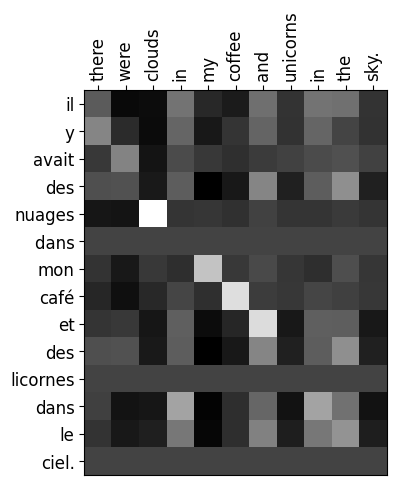

In [8]:
sentence_en = "there were clouds in my coffee and unicorns in the sky."
tokenized_en = tokenize(sentence_en, en_dict)
embedded_en = embed(tokenized_en, en_embeddings)

sentence_fr = "il y avait des nuages ​​dans mon café et des licornes dans le ciel."
tokenized_fr = tokenize(sentence_fr, fr_dict)
embedded_fr = embed(tokenized_fr, fr_embeddings)

alignment = calc_weights(embedded_fr, embedded_en)
# visualize weights
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(alignment,cmap='gray')
ax.xaxis.tick_top()
ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=12);
ax.set_yticks(np.arange(alignment.shape[0]));
ax.set_yticklabels(sentence_fr.split(" "), size=12);

### your code to compute the top-2 ###
flattened = alignment.flatten()
indices = np.argpartition(flattened, -2)[-2:]
indices_2d = np.unravel_index(indices, alignment.shape)
top1, top2 = list(zip(indices_2d[0], indices_2d[1]))
print(f'Most aligned: {sentence_fr.split(" ")[top1[0]]} - {sentence_en.split(" ")[top1[1]]}')
print(f'2nd most algined: {sentence_fr.split(" ")[top2[0]]} - {sentence_en.split(" ")[top2[1]]}')

### your code ###

1. What are the top 2 alignments shown in the figure?
2. On the rows you see flat lines for `ciel` and `dans` and `licornes`, why do you think that is?

**Answer:**

1.  'cafe - coffee' and 'nuages - clouds'
2. It is because they are unknown words, not included in the French vocabulary - the first dans is not recognized because of the invisible character mistakenly included in the french sentence string. Therefore they are encoded as vectors of 0s, not carrying any embedding information

####${\color{red}{Comments\ 3.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: Scaled Dot-product
Implement the scaled dot-product attention using the functions from above.



In [9]:
def attention(queries, keys, values):
    """  scaled dot-product attention
    queries: query matrix
    keys: key matrix
    value: value matrix
    """

    #### your code ####

    attention = calc_weights(queries, keys)@values
    #### your code ####
    return attention


attention_result = attention(embedded_fr, embedded_en, embedded_en)
print(attention_result.shape)
print(attention_result[0:2,:10])

(14, 300)
[[-0.0077802  -0.00345834 -0.01493142  0.05936939 -0.02286767 -0.00835552
   0.00079745 -0.03737862  0.0270674   0.05374082]
 [-0.00777829 -0.00336843 -0.01498988  0.05937157 -0.02285948 -0.00835695
   0.00085725 -0.03740797  0.02706951  0.05377672]]


####${\color{red}{Comments\ 3.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
cross-feedback comment section
```


${\color{red}{⚠️Comments\ end⚠️}}$